<a href="https://colab.research.google.com/github/Donyme/Restrictive_Sampling/blob/main/Restrictive_sampling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from torch import nn
from torchsummary import summary


In [3]:
torch.cuda.is_available()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [4]:
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [5]:
print(type(training_data))
print("Training data size: {}".format(len(training_data)))
print("Testing  data size: {}".format(len(test_data)))

<class 'torchvision.datasets.mnist.FashionMNIST'>
Training data size: 60000
Testing  data size: 10000


In [6]:
train_data_len = len(training_data)
test_data_len  = len(test_data)
img_size = (1, 28, 28)

In [7]:
img, label = training_data[10]
print(img.shape)
print(type(label))

torch.Size([1, 28, 28])
<class 'int'>


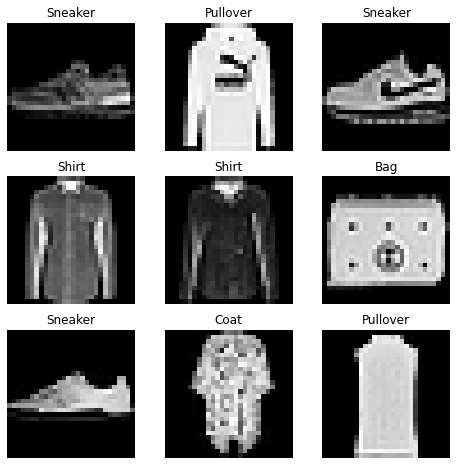

In [8]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [9]:
p = torch.rand(train_data_len, img_size[0], img_size[1], img_size[2])
print(p.shape)

torch.Size([60000, 1, 28, 28])


Image size: torch.Size([1, 28, 28]) label size: 0


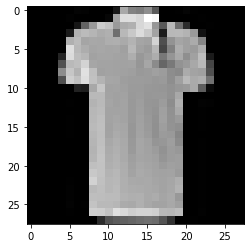

In [10]:
sample_idx = torch.randint(len(training_data), size=(1,)).item()

img , label = training_data[sample_idx]

print("Image size: {} label size: {}".format(img.shape, label))
figure = plt.figure(figsize=(4, 4))
plt.imshow(img.squeeze(), cmap="gray")


In [11]:
img = img.to(device)
print(img.is_cuda)

True


In [12]:
class SamplerDatasetInitializer(Dataset):
    def __init__(self, dataset_len):
        self.samples = torch.rand(dataset_len, img_size[0], img_size[1], img_size[2])

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx]

sampler_dataset = SamplerDatasetInitializer(train_data_len)


In [13]:
class SamplerDatasetIntermediate(Dataset):
    def __init__(self, data):
        self.samples = data

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx]

In [13]:
sampler_dataset.requires_grad = False
training_data.requires_grad   = False
test_data.requires_grad       = False

In [14]:
sampler_dataloader = DataLoader(sampler_dataset, batch_size=64, shuffle=False)
classifier_dataloader = DataLoader(training_data, batch_size=64, shuffle=False)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=False)

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


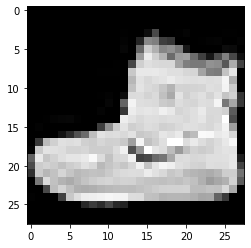

Label: 9


In [15]:
train_features, train_labels = next(iter(classifier_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

In [16]:
pixel_limit = 100

In [17]:
class SamplerNetwork(nn.Module):
    def __init__(self):
        super(SamplerNetwork, self).__init__()
        self.conv_1 = nn.Sequential(
            nn.Conv2d(
                in_channels=1,
                out_channels=32,
                kernel_size=3,
                padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.conv_2 = nn.Sequential(
            nn.Conv2d(
                in_channels=32,
                out_channels=64,
                kernel_size=3,

                padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )


        self.deconv_1 = nn.Sequential(
            nn.ConvTranspose2d(
              in_channels=64,
              out_channels=32,
              kernel_size=3,
              stride=2,
              padding=1,
              output_padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )

        self.deconv_2 = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=32,
                out_channels=1,
                kernel_size = 3,
                stride=2,
                padding=1, 
                output_padding=1),
            nn.ReLU()
        )

        self.drop = nn.Dropout2d(0.25)
        

    def forward(self, x):
        out = self.conv_1(x) 
        out = self.conv_2(out)
        out = self.deconv_1(out)
        out = self.deconv_2(out)

        return out

sampler_model = SamplerNetwork()

In [18]:
test_d = torch.rand(1, 1, 28, 28)
s1 = sampler_model(test_d)
print(type(s1))

<class 'torch.Tensor'>


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


<class '__main__.SamplerNetwork'>
torch.Size([1, 1, 28, 28])
torch.Size([1, 1, 28, 28])


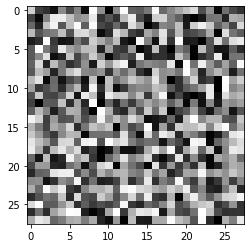

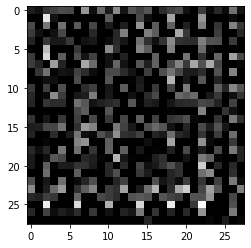

In [19]:
print(type(sampler_model))
ip = torch.rand(1, 1, 28, 28, requires_grad=False)
print(ip.shape)

out = sampler_model(ip)
print(out.shape)
plt.imshow(ip.squeeze(), cmap="gray")
plt.show()
plt.imshow(out.detach().numpy().squeeze(), cmap="gray")
plt.show()

In [20]:
sampler_model = sampler_model.cuda()
summary(sampler_model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
       BatchNorm2d-2           [-1, 32, 28, 28]              64
              ReLU-3           [-1, 32, 28, 28]               0
         MaxPool2d-4           [-1, 32, 14, 14]               0
            Conv2d-5           [-1, 64, 14, 14]          18,496
       BatchNorm2d-6           [-1, 64, 14, 14]             128
              ReLU-7           [-1, 64, 14, 14]               0
         MaxPool2d-8             [-1, 64, 7, 7]               0
   ConvTranspose2d-9           [-1, 32, 14, 14]          18,464
      BatchNorm2d-10           [-1, 32, 14, 14]              64
             ReLU-11           [-1, 32, 14, 14]               0
  ConvTranspose2d-12            [-1, 1, 28, 28]             289
             ReLU-13            [-1, 1, 28, 28]               0
Total params: 37,825
Trainable params: 

In [21]:
class ClassifierNetwork(nn.Module):
    def __init__(self):
        super(ClassifierNetwork, self).__init__()
        self.conv_1 = nn.Sequential(
            nn.Conv2d(
                in_channels=1,
                out_channels=32,
                kernel_size=3,
                padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.conv_2 = nn.Sequential(
            nn.Conv2d(
                in_channels=32,
                out_channels=64,
                kernel_size=3,
                padding=0),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )


        self.fc_1 = nn.Linear(in_features=64*6*6, out_features=600)
        self.drop = nn.Dropout2d(0.25)
        self.fc_2 = nn.Linear(in_features=600, out_features=120)
        self.fc_3 = nn.Linear(in_features=120, out_features=10)
        

    def forward(self, x):
        out = self.conv_1(x)
        out = self.conv_2(out)
        out = out.view(out.size(0), -1)
        out = self.fc_1(out)
        out = self.drop(out)
        out = self.fc_2(out)
        out = self.fc_3(out)
        
        return out
classifier_model = ClassifierNetwork()

In [22]:
classifier_model = classifier_model.cuda()
summary(classifier_model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
       BatchNorm2d-2           [-1, 32, 28, 28]              64
              ReLU-3           [-1, 32, 28, 28]               0
         MaxPool2d-4           [-1, 32, 14, 14]               0
            Conv2d-5           [-1, 64, 12, 12]          18,496
       BatchNorm2d-6           [-1, 64, 12, 12]             128
              ReLU-7           [-1, 64, 12, 12]               0
         MaxPool2d-8             [-1, 64, 6, 6]               0
            Linear-9                  [-1, 600]       1,383,000
        Dropout2d-10                  [-1, 600]               0
           Linear-11                  [-1, 120]          72,120
           Linear-12                   [-1, 10]           1,210
Total params: 1,475,338
Trainable params: 1,475,338
Non-trainable params: 0
---------------------------

In [27]:
# train sampler step
def train_sampler_loop (
    sampler_dataloader, classifier_dataloader,
    sampler_model,      classifier_model,
    sampler_loss_fn,
    sampler_optimizer):
  
  next_sampler_data_list = []
  size = len(sampler_dataloader.dataset)
  loop_parameter = 1

  for batch, (sampler_X, classifier_data) in enumerate(zip(sampler_dataloader, classifier_dataloader)):

      classifier_X, classifier_y = classifier_data[0], classifier_data[1]
      sampler_X    = sampler_X.cuda()
      classifier_X = classifier_X.cuda()
      classifier_y = classifier_y.cuda()

      for itr in range(0, loop_parameter):

        sampler_pred = sampler_model(sampler_X.clone())
        # extract pixel_limit values in sample pred or in sample network
        # sampler_pred = torch.einsum('...ij, ...ij -> ...ij', sampler_pred, classifier_X)
        classifier_pred = classifier_model(sampler_pred.cuda())
        loss = classifier_loss_fn(classifier_pred, classifier_y)

        sampler_optimizer.zero_grad()
        loss.backward(retain_graph=True)

        with torch.no_grad():
          sampler_optimizer.step()
          sampler_X = sampler_pred.clone()
          sampler_X = sampler_X.cuda()

# train classifier step
def train_classifier_loop (
    sampler_dataloader, classifier_dataloader,
    sampler_model,      classifier_model,
    classifier_loss_fn,
    classifier_optimizer):

  size = len(sampler_dataloader.dataset)
  for batch, (sampler_X, classifier_data) in enumerate(zip(sampler_dataloader, classifier_dataloader)):
      
      classifier_X, classifier_y = classifier_data[0], classifier_data[1]
      sampler_X    = sampler_X.cuda()
      classifier_X = classifier_X.cuda()
      classifier_y = classifier_y.cuda()
      sampler_pred = sampler_model(sampler_X.clone())

      # extract pixel_limit values in sample pred or in sample network
      # sampler_pred = torch.einsum('...ij, ...ij -> ...ij', sampler_pred, classifier_X)

      classifier_pred = classifier_model(sampler_pred.cuda())
      loss = classifier_loss_fn(classifier_pred, classifier_y)

      classifier_optimizer.zero_grad()
      loss.backward(retain_graph=True)
      classifier_optimizer.step()


      '''
      if batch % 100 == 0:
          loss, current = loss.item(), batch * len(X)
          print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
      '''

In [24]:
torch.autograd.set_detect_anomaly(True)

In [28]:
# hyperparameters

learning_rate = 1e-3
batch_size = 64
epochs = 2

sampler_optimizer    = torch.optim.Adam(sampler_model.parameters(), lr=learning_rate, betas=(0.5, 0.999))
classifier_optimizer = torch.optim.Adam(classifier_model.parameters(), lr=learning_rate, betas=(0.5, 0.999))

sampler_loss_fn = nn.CrossEntropyLoss().cuda() # incorporate number of iterations as a penalty
classifier_loss_fn = nn.CrossEntropyLoss().cuda()



In [ ]:
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_sampler_loop(sampler_dataloader, classifier_dataloader, sampler_model, classifier_model, sampler_loss_fn, sampler_optimizer)
    train_classifier_loop(sampler_dataloader, classifier_dataloader, sampler_model, classifier_model, classifier_loss_fn, classifier_optimizer)

print("Done!")

In [ ]:
torch.cuda.empty_cache()

In [ ]:
import gc

gc.collect()